The purpose of this notebook is to show how to use the agn object and its pipelines. The agn object is a macromodel of the other classes designed to streamline calculations. It can host an accretion disk, a diffuse continuum, a torus, and multiple broad line regions (which may represent various ionic species). 

Setting up the agn object is the most important part, so we will start there. The default accretion disk is the Shakura + Sunyaev disk, though the Novikov + Thorne disk may also be implimented using "visc_temp_prof"="NT".

In [1]:
import numpy as np
import sys

sys.path.append("../src/")
from amoeba.Classes.agn import Agn
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt

In [2]:
# include some specific parameters for disk
my_agn_dictionary = {
    "smbh_mass_exp": 8.72,
    "redshift_source": 0.44,
    "inclination_angle": 38,
    "eddington_ratio": 0.04,
    "number_grav_radii": 2000,
    "resolution": 500,
    "corona_height": 20,
}
my_basic_agn = Agn("I'm number one!", **my_agn_dictionary)

Let's take a look at the AGN's current components!

In [3]:
print(my_basic_agn.components)

{}


Right now the macromodel is initialized, but has nothing inside. We can change that using some of its methods.

## Accretion disk implimentation

In [4]:
my_basic_agn.add_default_accretion_disk()
print(my_basic_agn.components)

{'accretion_disk': <amoeba.Classes.accretion_disk.AccretionDisk object at 0x130f81d30>}


Armed with our accretion disk embedded in the AGN, we can run all the usual accretion disk methods

In [5]:
embedded_disk = my_basic_agn.components["accretion_disk"]
wavelength = 500  # nm
flux_distribution = embedded_disk.calculate_surface_intensity_map(wavelength)
disk_transfer_function = embedded_disk.construct_accretion_disk_transfer_function(
    wavelength
)

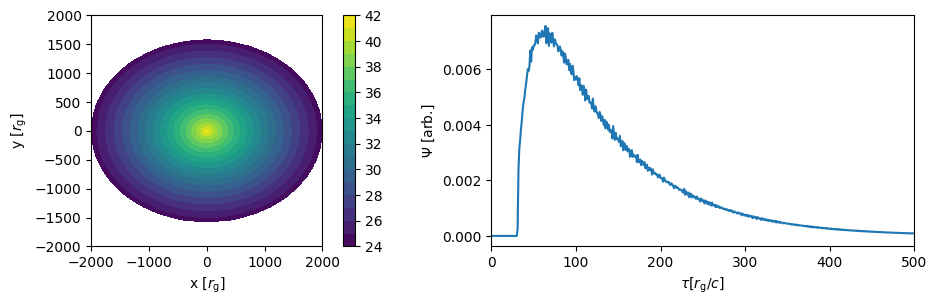

In [6]:
X, Y = flux_distribution.get_plotting_axes()
tau_ax = np.linspace(0, len(disk_transfer_function) - 1, len(disk_transfer_function))

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
contours = ax[0].contourf(X, Y, np.log10(flux_distribution.flux_array), 20)
cbar = plt.colorbar(contours, ax=ax[0])
ax[0].set_aspect(1)
ax[0].set_xlabel(r"x [$r_{\rm{g}}$]")
ax[0].set_ylabel(r"y [$r_{\rm{g}}$]")

ax[1].plot(tau_ax, disk_transfer_function)
fig.set_figheight(3)
ax[1].set_xlim(0, 500)
ax[1].set_xlabel(r"$\tau[r_{\rm{g}}/ c ]$")
ax[1].set_ylabel(r"$\Psi$ [arb.]")

plt.show()

Alternatively to extracting the accretion disk object, you can create these directly from the Agn object.

In [7]:
direct_flux_distribution = my_basic_agn.visualize_static_accretion_disk(wavelength)
direct_transfer_function = my_basic_agn.calculate_accretion_disk_transfer_function(
    wavelength
)

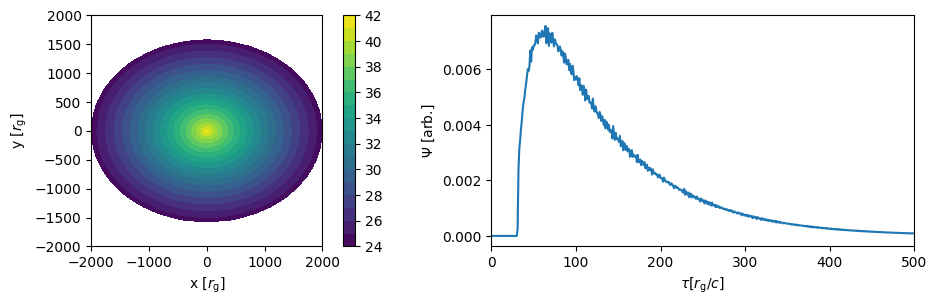

In [8]:
X, Y = direct_flux_distribution.get_plotting_axes()
tau_ax = np.linspace(
    0, len(direct_transfer_function) - 1, len(direct_transfer_function)
)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
contours = ax[0].contourf(X, Y, np.log10(direct_flux_distribution.flux_array), 20)
cbar = plt.colorbar(contours, ax=ax[0])
ax[0].set_aspect(1)
ax[0].set_xlabel(r"x [$r_{\rm{g}}$]")
ax[0].set_ylabel(r"y [$r_{\rm{g}}$]")

ax[1].plot(tau_ax, direct_transfer_function)
fig.set_figheight(3)
ax[1].set_xlim(0, 500)
ax[1].set_xlabel(r"$\tau[r_{\rm{g}}/ c ]$")
ax[1].set_ylabel(r"$\Psi$ [arb.]")


plt.show()

## Broad Line Region implimentation

Adding a broad line region (BLR) is a little more tricky, since we need to construct the streamlines to define the BLR.

In [9]:
from amoeba.Classes.blr_streamline import Streamline
from amoeba.Classes.blr import BroadLineRegion

In [10]:
max_blr_height = 500  # rg
rest_frame_wavelength_in_nm = 388  # nm
my_blr_dictionary = {
    "max_height": max_blr_height,
    "rest_frame_wavelength_in_nm": rest_frame_wavelength_in_nm,
    "radial_step": 10,
    "height_step": 10,
}
my_basic_agn.add_blr(**my_blr_dictionary)
for item in my_basic_agn.components:
    print(item)

accretion_disk
blr_0


Note that an index has been appended to the blr. This is to keep track of various blr objects within the AGN, and by default index "0" is selected. Let's add a second blr.

In [11]:
rest_frame_wavelength_in_nm_2 = 710  # nm
my_blr_dictionary = {
    "max_height": max_blr_height,
    "rest_frame_wavelength_in_nm": rest_frame_wavelength_in_nm_2,
    "radial_step": 10,
    "height_step": 10,
}
blr_index = 88.2
my_basic_agn.add_blr(blr_index=blr_index, **my_blr_dictionary)
for item in my_basic_agn.components:
    print(item)

accretion_disk
blr_0
blr_88.2


If you've used the blr object before, you may be reminded that these are just initializations. The emitting region must be added to each of these after initialization with streamlines. Streamlines follow the Yang et. al prescription.

In [12]:
inner_launch_radius = 2000  # rg
inner_launch_angle = 20  # degrees
inner_characteristic_distance = (
    200  # rg, defines the acceleration of the material along the streamline
)
inner_asymptotic_velocity = 0.05  # v/c, defines maximum velocity along streamline

inner_streamline = Streamline(
    inner_launch_radius,
    inner_launch_angle,
    max_blr_height,
    inner_characteristic_distance,
    inner_asymptotic_velocity,
)
outer_launch_radius = 3000  # rg
outer_launch_angle = 40  # degrees
outer_characteristic_distance = (
    200  # rg, defines the acceleration of the material along the streamline
)
outer_asymptotic_velocity = 0.05  # v/c, defines maximum velocity along streamline

outer_streamline = Streamline(
    outer_launch_radius,
    outer_launch_angle,
    max_blr_height,
    outer_characteristic_distance,
    outer_asymptotic_velocity,
)

my_blr_streamlines_0 = {
    "InnerStreamline": inner_streamline,
    "OuterStreamline": outer_streamline,
}

far_outer_launch_radius = 3100  # rg
far_outer_launch_angle = 45  # degrees
far_outer_characteristic_distance = (
    200  # rg, defines the acceleration of the material along the streamline
)
far_outer_asymptotic_velocity = 0.2  # v/c, defines maximum velocity along streamline

far_outer_streamline = Streamline(
    far_outer_launch_radius,
    far_outer_launch_angle,
    max_blr_height,
    far_outer_characteristic_distance,
    far_outer_asymptotic_velocity,
)

my_blr_streamlines_882 = {
    "InnerStreamline": outer_streamline,
    "OuterStreamline": far_outer_streamline,
}

In [13]:
my_basic_agn.add_streamline_bounded_region_to_blr(blr_index=0, **my_blr_streamlines_0)
my_basic_agn.add_streamline_bounded_region_to_blr(
    blr_index=88.2, **my_blr_streamlines_882
);

Now that the embedded BLR are set up within the AGN, we may visualize its projection.

In [14]:
projection_blr_0 = my_basic_agn.visualize_static_blr(blr_index=0)
projection_blr_882 = my_basic_agn.visualize_static_blr(blr_index=88.2)

0.0 inf
532.6576045152464 570.322040955438
velocities [-0.02054984  0.04773333]
0.0 inf
873.4053481248732 1095.5961423184078
velocities [-0.06903584  0.15621858]


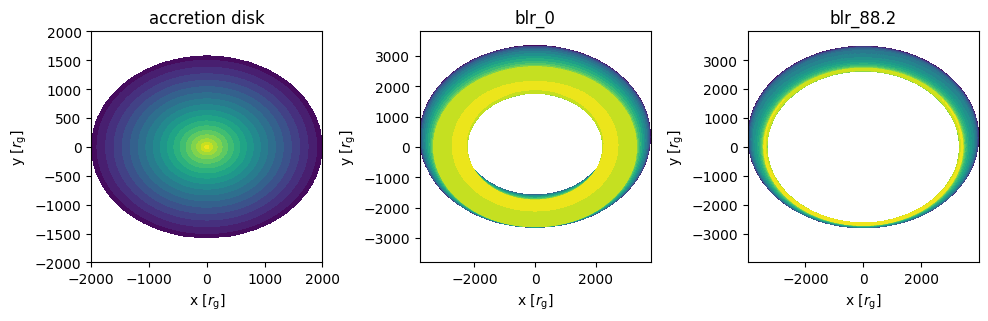

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

X, Y = direct_flux_distribution.get_plotting_axes()
ax[0].contourf(X, Y, np.log10(direct_flux_distribution.flux_array), 20)
ax[0].set_title("accretion disk")

X, Y = projection_blr_0.get_plotting_axes()
ax[1].contourf(X, Y, np.log10(projection_blr_0.flux_array), 20)
ax[1].set_title("blr_0")

X, Y = projection_blr_882.get_plotting_axes()
ax[2].contourf(X, Y, np.log10(projection_blr_882.flux_array), 20)
ax[2].set_title("blr_88.2")

for axis in ax:
    axis.set_aspect(1)
    axis.set_xlabel(r"x [$r_{\rm{g}}$]")
    axis.set_ylabel(r"y [$r_{\rm{g}}$]")


plt.show()

Let's say we want to use this system and change our point of view. As long as the accretion disk is a basic type, you can simply update parameters with the set of update methods. This will in turn update all component models of the AGN.

In [16]:
new_inclination = 80

my_basic_agn.update_inclination(new_inclination)

direct_flux_distribution = my_basic_agn.visualize_static_accretion_disk(wavelength)
projection_blr_0 = my_basic_agn.visualize_static_blr(blr_index=0)
projection_blr_882 = my_basic_agn.visualize_static_blr(blr_index=88.2)

0.0 inf
537.4132053045637 577.397927295942
velocities [-0.03287138  0.0388616 ]
0.0 inf
897.4283761173516 1142.2891190676096
velocities [-0.11042925  0.12964107]


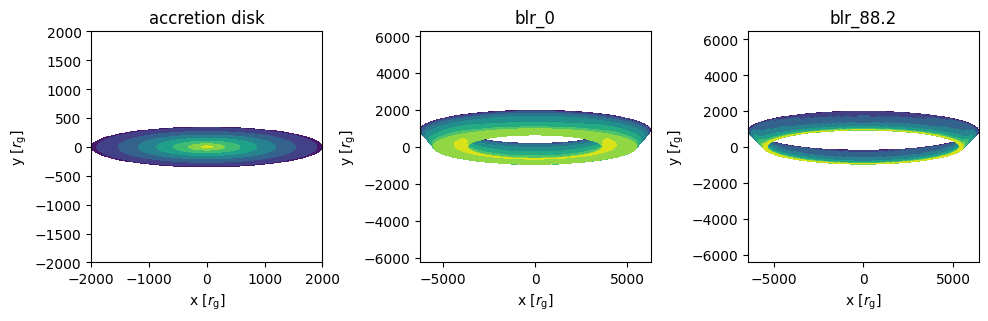

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

X, Y = direct_flux_distribution.get_plotting_axes()
ax[0].contourf(X, Y, np.log10(direct_flux_distribution.flux_array))
ax[0].set_title("accretion disk")

X, Y = projection_blr_0.get_plotting_axes()
ax[1].contourf(X, Y, np.log10(projection_blr_0.flux_array))
ax[1].set_title("blr_0")

X, Y = projection_blr_882.get_plotting_axes()
ax[2].contourf(X, Y, np.log10(projection_blr_882.flux_array))
ax[2].set_title("blr_88.2")

for axis in ax:
    axis.set_aspect(1)
    axis.set_xlabel(r"x [$r_{\rm{g}}$]")
    axis.set_ylabel(r"y [$r_{\rm{g}}$]")


plt.show()

The blr projections shown are technically the integrated flux over all wavelengths. We can instead select coponents which become projected into specific wavelength ranges or filters.

In [18]:
from speclite.filters import load_filter

filter_1 = load_filter("lsst2023-g")
projection_blr_0_1 = my_basic_agn.visualize_static_blr(
    blr_index=0, speclite_filter=filter_1
)
projection_blr_882_1 = my_basic_agn.visualize_static_blr(
    blr_index=88.2, speclite_filter=filter_1
)
filter_2 = load_filter("lsst2023-y")
projection_blr_0_2 = my_basic_agn.visualize_static_blr(
    blr_index=0, speclite_filter=filter_2
)
projection_blr_882_2 = my_basic_agn.visualize_static_blr(
    blr_index=88.2, speclite_filter=filter_2
)

390.9000000000206 564.2000000000601
537.4132053045637 577.397927295942
velocities [-0.03287138  0.0388616 ]
390.90000000002055 564.2000000000598
897.4283761173516 1142.2891190676096
velocities [-0.11042925  0.12964107]
returning case 1
897.4283761173516 564.2000000000598
911.5000000001389 1074.8000000001762
537.4132053045637 577.397927295942
velocities [-0.03287138  0.0388616 ]
returning case 2
577.397927295942 911.5000000001389
911.5000000001387 1074.800000000176
897.4283761173516 1142.2891190676096
velocities [-0.11042925  0.12964107]


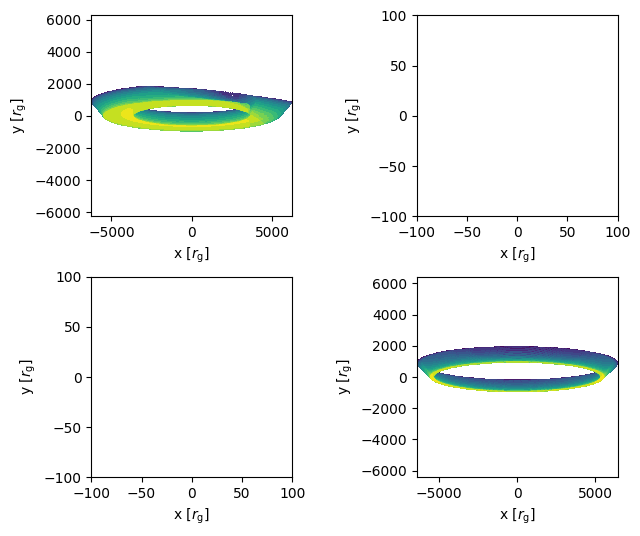

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(7, 6))

# in the top row, plot BLR with index 0
X, Y = projection_blr_0_1.get_plotting_axes()
ax[0, 0].contourf(X, Y, np.log10(projection_blr_0_1.flux_array), 20)
X, Y = projection_blr_0_2.get_plotting_axes()
ax[0, 1].contourf(X, Y, np.log10(projection_blr_0_2.flux_array), 20)

# in the bottom row, plot BLR with index 88.2
X, Y = projection_blr_882_1.get_plotting_axes()
ax[1, 0].contourf(X, Y, np.log10(projection_blr_882_1.flux_array), 20)
X, Y = projection_blr_882_2.get_plotting_axes()
ax[1, 1].contourf(X, Y, np.log10(projection_blr_882_2.flux_array), 20)

# left column is filter_1, right column is filter_2

for axax in ax:
    for axis in axax:
        axis.set_aspect(1)
        axis.set_xlabel(r"x [$r_{\rm{g}}$]")
        axis.set_ylabel(r"y [$r_{\rm{g}}$]")
plt.subplots_adjust(hspace=0.3, wspace=0.5)

plt.show()

## Diffuse continuum implimentation

The diffuse continuum (DC) is believed to contribute to the reverberation properties of the AGN. We will show how a toy model may be implimented, which may be adjusted with any expected or calculated emission properties. This follows the Korista + Goad procedure for a given time delay spectrum.

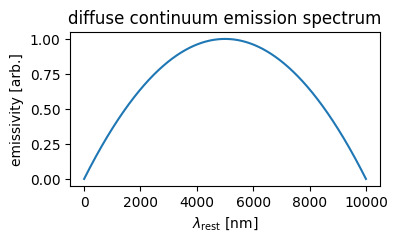

In [20]:
dc_wavelengths = np.linspace(1, 10000, 10000)
dc_emissivities = dc_wavelengths * np.flip(dc_wavelengths)  # some basic quadratic
dc_emissivities /= np.max(dc_emissivities)  # normalize

diffuse_continuum_kwargs = {
    "cloud_density_radial_dependence": 0,
    "r_in_in_gravitational_radii": inner_launch_radius,
    "r_out_in_gravitational_radii": far_outer_launch_radius,
    "rest_frame_wavelengths": dc_wavelengths,
    "responsivity_constant": 0.5,
    "emissivity_etas": dc_emissivities,
}

my_basic_agn.add_diffuse_continuum(**diffuse_continuum_kwargs)

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(dc_wavelengths, dc_emissivities)
ax.set_title("diffuse continuum emission spectrum")
ax.set_xlabel(r"$\lambda_{\rm{rest}}$ [nm]")
ax.set_ylabel("emissivity [arb.]")
plt.show()

We can project the emission of the diffuse continuum just like each other component

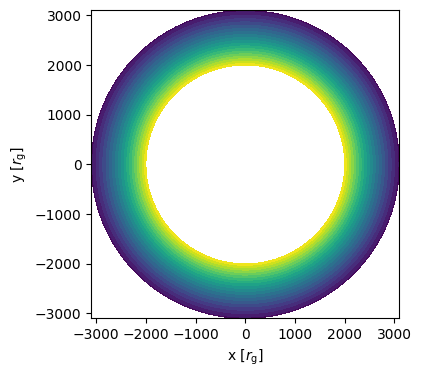

In [21]:
my_diffuse_continuum_emission = my_basic_agn.visualize_static_diffuse_continuum(500)
fig, ax = plt.subplots(figsize=(4, 4))
X, Y = my_diffuse_continuum_emission.get_plotting_axes()

ax.contourf(X, Y, np.log10(my_diffuse_continuum_emission.flux_array), 20)
ax.set_xlabel(r"x [$r_{\rm{g}}$]")
ax.set_ylabel(r"y [$r_{\rm{g}}$]")
ax.set_aspect(1)
plt.show()

Currently, there is not torus emission implimented. However, when this update is provided it will have a small tutorial here.

## Visualization pipeline

Going through each of these components one by one just to see what they look like can get tedious. This is why a visualization pipeline is created in order to create all components with one method. Let's update the wavelength, redshift, and inclination first.

In [22]:
my_basic_agn.update_inclination(28)
my_basic_agn.update_redshift(2.1)
# recall the blr was initialized at rest frame 388 and 710 nm.

wavelength_ranges = [[1000, 1300], [2000, 2100]]

visualization = my_basic_agn.visualize_agn_pipeline(
    observer_frame_wavelengths_in_nm=wavelength_ranges
)

999.9999999999999 1300.0
1148.5390095932892 1221.7981877391667
velocities [-0.01567024  0.0461287 ]
999.9999999999998 1299.9999999999995
1891.621489317527 2320.084654059512
velocities [-0.05264316  0.15032938]
returning case 1
1891.621489317527 1299.9999999999995
1999.9999999999998 2100.0
1148.5390095932892 1221.7981877391667
velocities [-0.01567024  0.0461287 ]
returning case 2
1221.7981877391667 1999.9999999999998
1999.9999999999995 2100.0
1891.621489317527 2320.084654059512
velocities [-0.05264316  0.15032938]


In [23]:
print(np.shape(visualization))
print(type(visualization[0]))

(2,)
<class 'amoeba.Classes.flux_projection.FluxProjection'>


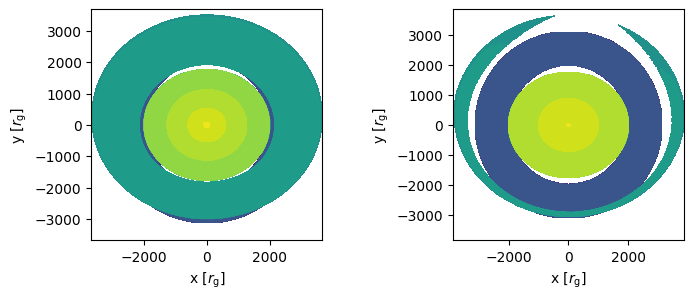

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
X, Y = visualization[0].get_plotting_axes()
ax[0].contourf(X, Y, np.log10(visualization[0].flux_array), 20)

X, Y = visualization[1].get_plotting_axes()
ax[1].contourf(X, Y, np.log10(visualization[1].flux_array), 20)

for axis in ax:
    axis.set_aspect(1)
    axis.set_xlabel(r"x [$r_{\rm{g}}$]")
    axis.set_ylabel(r"y [$r_{\rm{g}}$]")
plt.subplots_adjust(wspace=0.4)
plt.show()

The accretion disk dominates the flux and the other components are not very interesting. Note that the diffuse continuum is assumed to be some radial distribution of clouds independent of inclination angle, so it does not project like the other components.

We can instead project each piece independenly.

In [25]:
component_projections = my_basic_agn.visualize_agn_pipeline(
    observer_frame_wavelengths_in_nm=wavelength_ranges, return_components=True
)

999.9999999999999 1300.0
1148.5390095932892 1221.7981877391667
velocities [-0.01567024  0.0461287 ]
999.9999999999998 1299.9999999999995
1891.621489317527 2320.084654059512
velocities [-0.05264316  0.15032938]
returning case 1
1891.621489317527 1299.9999999999995
1999.9999999999998 2100.0
1148.5390095932892 1221.7981877391667
velocities [-0.01567024  0.0461287 ]
returning case 2
1221.7981877391667 1999.9999999999998
1999.9999999999995 2100.0
1891.621489317527 2320.084654059512
velocities [-0.05264316  0.15032938]


In [26]:
print(np.shape(component_projections))

(2, 3)


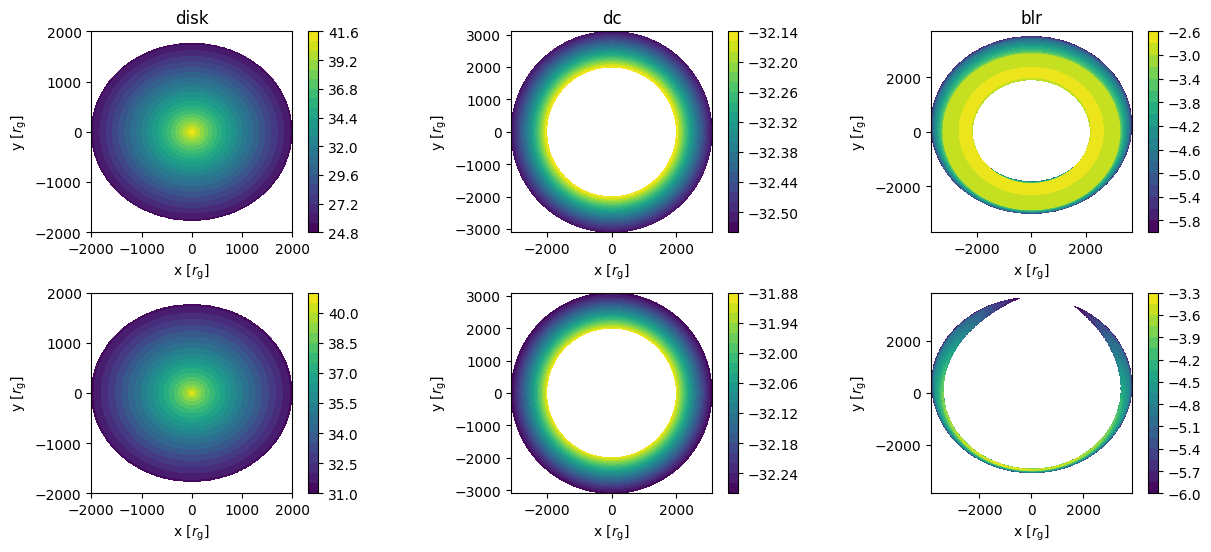

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

for row, wavelength_range in enumerate(component_projections):
    for column, current_flux_projection in enumerate(wavelength_range):
        X, Y = current_flux_projection.get_plotting_axes()
        cur_conts = ax[row, column].contourf(
            X, Y, np.log10(current_flux_projection.flux_array), 20
        )
        plt.colorbar(cur_conts, ax=ax[row, column])
        ax[row, column].set_xlabel(r"x [$r_{\rm{g}}$]")
        ax[row, column].set_ylabel(r"y [$r_{\rm{g}}$]")
        ax[row, column].set_aspect(1)

ax[0, 0].set_title("disk")
ax[0, 1].set_title("dc")
ax[0, 2].set_title("blr")

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()